# Waveform Shape

Neural oscillations vary in their waveform shape, which can 

### Issue

Neural oscillations are often non-sinusoidal, and exhibit variability in their waveform shape. 

This can cause issues with analysis methods that assume sinusoidal bases. 

This includes confounded power measurements (due to harmonics), spurious phase-amplitude coupling (PAC), and biased filter outputs.

### Solution

Waveform shape can and should be explicitly checked and measured.

### Related Work

Core citations / links:
- [When brain rhythms aren't ‘rhythmic’: implication for their mechanisms and meaning](https://doi.org/10.1016/j.conb.2016.06.010), Jones, 2016
- [Brain Oscillations and the Importance of Waveform Shape](https://doi.org/10.1016/j.tics.2016.12.008), Cole & Voytek, 2017

### Related Discussion / Examples

- To Add: ByCycle tutorials.
- To Add: PAC example on ByCycle. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#from pactools import Comodulogram

from fooof.plts.spectra import plot_spectra, plot_spectrum_shading
from fooof.utils import trim_spectrum

from neurodsp.filt import filter_signal
from neurodsp.sim import sim_oscillation, sim_combined
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times, set_random_seed

In [ ]:
# Add path and import custom code for the project
import sys
sys.path.append('code')
from utils import mu_wave
from plts import savefig

## Settings

In [2]:
import seaborn as sns
sns.set_context('poster')

In [3]:
# Set random seed
set_random_seed(808)

In [4]:
# Set the average function to use
avg_func = np.mean

In [5]:
# Define general simulation settings
n_seconds = 25
fs = 1000

times = create_times(n_seconds, fs)

In [6]:
# Define parameters for the simulations
exp = -2.0
ap_filt = (2, 150)

cf = 10
rdsym = 0.05

In [7]:
# Define ranges of interest
psd_range = (3, 35)
alpha_range = (8, 12)
beta_range = (15, 35)
broad_range = (5, 150)

In [8]:
# Define range of values to use for oscillation asymmetry
rdsyms = [0.50, 0.625, 0.75, 0.875, 1.0]

In [9]:
# Collect parameters and set up simulations
comps = {'sim_powerlaw' : {'exponent' : exp, 'f_range' : ap_filt},
         'sim_oscillation' : {'freq' : cf, 'cycle' : 'asine', 'rdsym' : rdsym}}

# Define relative power of the signal components
comp_vars = [1, 0.8]

In [10]:
plt_kwargs = {'xlabel' : '', 'ylabel' : '', 'alpha' : [0.75, 0.75]}

In [11]:
alpha_color = '#1882d9'

## Simulate Time Series


For this example, we will simulate a signal, with an asymmetric oscillation. 

In [12]:
# Simulate an asymmetric oscillation
osc = sim_oscillation(n_seconds, fs, cf, cycle='asine', rdsym=rdsym)

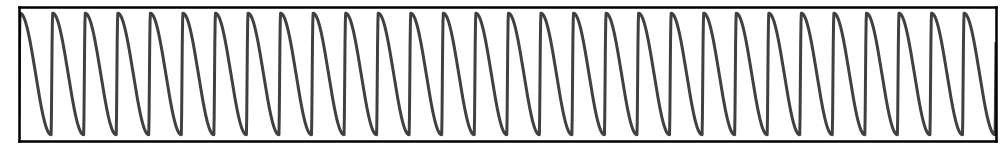

In [13]:
# Visualize the asymmertic oscillation
plot_time_series(times, osc, xlim=[5, 8], **plt_kwargs)
plt.xticks([]); plt.yticks([]);

In [14]:
# Simulate the combined time series
sig = sim_combined(n_seconds, fs, comps, comp_vars)

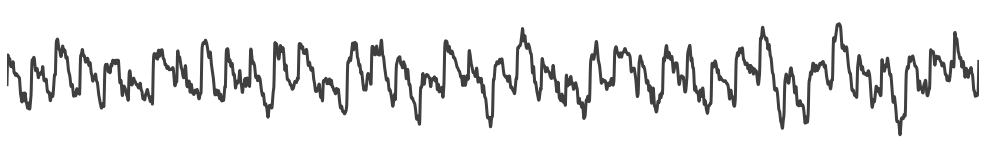

In [15]:
# Plot the simulated time series
plot_time_series(times, sig, xlim=[20, 24], **plt_kwargs)
plt.axis('off')
plt.savefig('figures/05-ts.pdf', bbox_inches='tight')

### Filter Time Series

Next, let's explore filtering our simulated signal. 

With the filtering we want to pay particular attention to how narrowband filters distort the shape of asymmetric oscillations.

In [16]:
# Filter the signal, including a broadband filter, and the alpha range
sig_filt_bb = filter_signal(sig, fs, 'bandpass', broad_range)
sig_filt_al = filter_signal(sig, fs, 'bandpass', alpha_range)

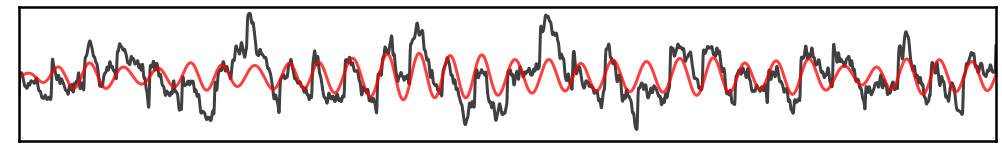

In [17]:
# 
plot_time_series(times, [sig, sig_filt_al], xlim=[5, 8], **plt_kwargs)
plt.xticks([]); plt.yticks([]);
plt.savefig('figures/05-ts_filt.pdf', bbox_inches='tight')

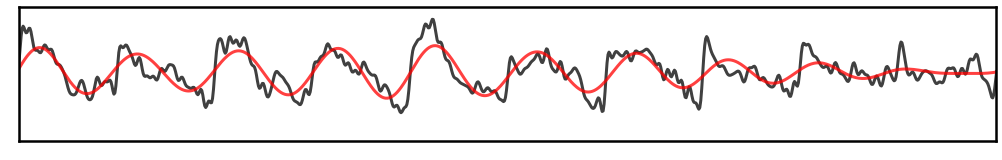

In [18]:
# Zoom in, and plot the alpha filtered signal, compared to a lightly filtered signal
plot_time_series(times, [sig_filt_bb, sig_filt_al], xlim=[4, 5], **plt_kwargs)
plt.xticks([]); plt.yticks([]);
plt.savefig('figures/05-ts_bb_filt.pdf', bbox_inches='tight')

### Compute Power Spectra

Next, let's compute the power spectrum of the simulated signal. 

In the power spectrum, we will be paying attention to harmonics that arise due to the asymmetric oscillation. 

Note, in the following plot, that are are clear harmonics, that show up in the beta range. 

In [19]:
# Compute the power spectrum of the signal
freqs1, powers1 = trim_spectrum(*compute_spectrum(sig, fs, nperseg=fs), psd_range)

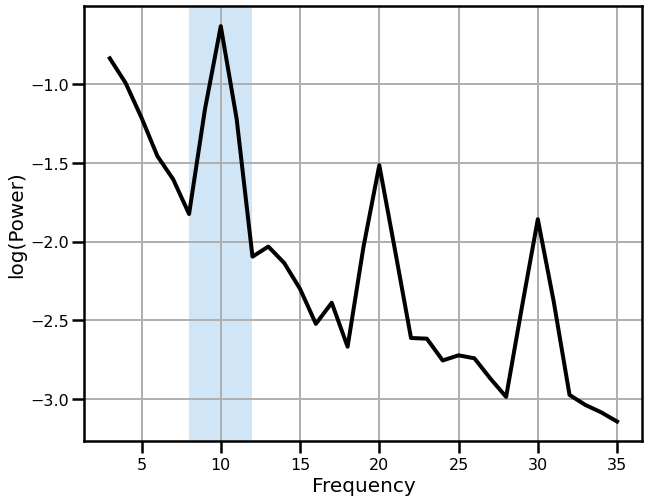

In [20]:
# Plot the power spectrum
plot_spectrum_shading(freqs1, powers1, alpha_range, color='k',
                      log_freqs=False, log_powers=True,
                      lw=4, shade_colors=alpha_color)
plt.savefig('figures/05-psd.pdf', bbox_inches='tight')

### Compare across asymmetry values

Next, let's extend the analysis, and simulate signals across different oscillation asymmetries. 



In [21]:
# Set the number of simulations to run
n_sims = 5

In [22]:
# Initialize variables to collect some measures of interest
beta_pows = []
all_pows = []

# Simulate some signals across difference asymmetry values
for rdsym in rdsyms:
    
    # Set up the parameter definition for the current set of sims
    comps = {'sim_powerlaw' : {'exponent' : exp, 'f_range' : ap_filt},
             'sim_oscillation' : {'freq' : cf, 'cycle' : 'asine', 'rdsym' : rdsym}}

    temp = []
    for ind in range(n_sims):
        
        # Create the signal
        cur_sig = sim_combined(n_seconds, fs, comps, comp_vars)
        
        # Compute the spectrum and collect the measured beta power
        cur_freqs, cur_pows = compute_spectrum(cur_sig, fs, nperseg=fs)
        _, beta_pow = trim_spectrum(cur_freqs, cur_pows, beta_range)
        temp.append(avg_func(beta_pow))

    beta_pows.append(avg_func(temp))
    all_pows.append(cur_pows)

In [23]:
# Extract the labels for the asymetry values that were simulated
labels = ['rdsym=' + str(round(val, 2)) for val in rdsyms]

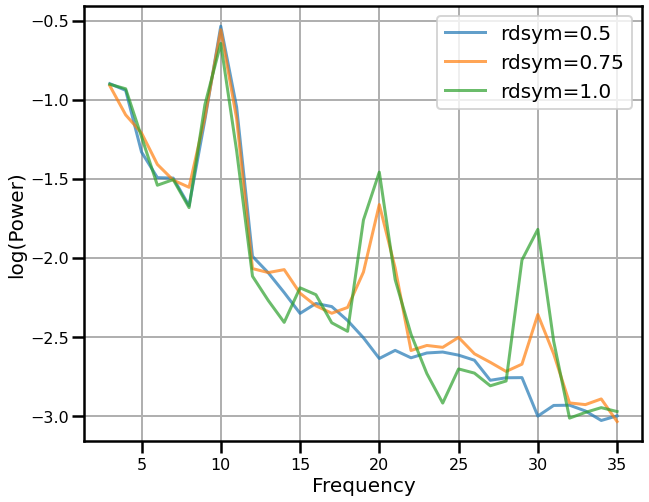

In [24]:
# Plot example power spectra, across a subset of the simulated oscillation asymmetries
plot_spectra(*trim_spectrum(cur_freqs, np.array(all_pows[0::2]), psd_range),
             lw=3, labels=labels[0::2], log_powers=True, alpha=0.7)
plt.legend(prop={'size': 20})
plt.savefig('figures/05-psd_shapes.pdf', bbox_inches='tight')

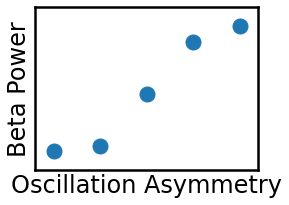

In [25]:
# Plot the relationship between measured beta power & oscillation asymmetry
_, ax = plt.subplots(figsize=(4, 3))
ax.plot(rdsyms, beta_pows, '.', ms=30)
ax.set_xlabel('Oscillation Asymmetry')
ax.set_ylabel('Beta Power')
ax.set_xlim([np.min(rdsyms) - 0.05, np.max(rdsyms) + 0.05])
ax.set_ylim([np.min(beta_pows) - 0.0005, np.max(beta_pows) + 0.0005])
ax.set_xticks([]); ax.set_yticks([]);
plt.savefig('figures/05-beta_vs_shape.pdf', bbox_inches='tight')

In the above, we can see that the the measured beta power tracks the waveform shape of the simulated oscillation. 

Keep in mind this is relating measured _beta_ power to the shape of an _alpha_ oscillation. 

In this simulation, there is no actual beta power. This shows spurious power, due to the harmonics. 

### Compute Phase-Amplitude Coupling

Finally, let's examine phase-amplitude coupling.

Phase-amplitude coupling is an analysis to investigate coupling between multiple, distinct oscillations. 

Note that in our example signal, there is only one oscillation, and so there can be no true coupling between multiple periodic components. Despite this, non-sinusoidal rhythms can induce artifactual phase-amplitude coupling. 

In [26]:
# Define the frequency ranges to use for PAC analysis
low_fq_range = np.linspace(1, 25, 50)
high_fq_range = np.linspace(50, 150, 50)

In [27]:
# Define the PAC estimator
estimator = Comodulogram(fs,
                         low_fq_range=low_fq_range,
                         high_fq_range=high_fq_range,
                         method='tort', progress_bar=False)

In [28]:
# Estimate phase-amplitude coupling
estimator.fit(sig);

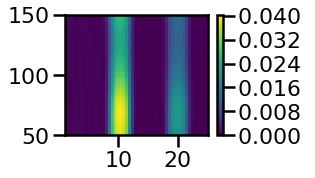

In [29]:
# Plot the measured PAC
estimator.plot(label=False);
plt.savefig('figures/05-pac.pdf', bbox_inches='tight')

### Conclusion

Many of the methods that are commonly used assume and embody assumptions of sinusoidality.

This can be an issue, as the observed oscillations in neural data are often neural data. 

As we've explored here, non-sinusoidal oscillations can induce spurious or biased measures of power, phase-amplitude coupling, and filter outputs. 

These issues can be addressed by explicitly measuring waveform shape, both as a measure of interest itself, and to check whether waveform shape measures may explain any other measured changes. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import neurodsp.spectral as spec
import neurodsp.filt.filter as filter1
import scipy.signal
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
# change colors to fit the rest of figure
mu_color = "k"
sinus_color = "r"
harmonic_color = "b"

colors = [mu_color, sinus_color, harmonic_color]

In [ ]:
# create signals
fs = 1000
base_frequency = 10
time = np.arange(0, 2, 0.001)
signal_alpha, signal_beta = mu_wave(time, 0, base_frequency)
signal_mu = signal_alpha + signal_beta

signal_mu_filt = filter1.filter_signal(
    signal_mu, fs, "bandpass", [15, 25], remove_edges=False
)

# regulat filter order for changing attenuation for flanks
signal_beta_filt = filter1.filter_signal(
    signal_beta, fs, "bandpass", [17.5, 22.5], n_cycles=3, remove_edges=False
)
signal_alpha_filt = filter1.filter_signal(
    signal_alpha, fs, "bandpass", [15, 25], remove_edges=False
)

In [ ]:
# spectrum
fmax = 50
freqs, spec_mu = spec.compute_spectrum(signal_mu, fs, f_range=(2, fmax))
freqs, spec_beta = spec.compute_spectrum(signal_beta, fs, f_range=(2, fmax))
freqs, spec_beta_filt = spec.compute_spectrum(
    signal_beta_filt, fs, f_range=(2, fmax)
)
freqs, spectrum_alpha = spec.compute_spectrum(
    signal_alpha, fs, f_range=(2, fmax)
)


In [ ]:
beta_env = np.abs(scipy.signal.hilbert(signal_beta_filt))
mu_env = np.abs(scipy.signal.hilbert(signal_mu_filt))
phase_alpha = np.angle(scipy.signal.hilbert(signal_alpha))

n_bins = 21
bins = np.linspace(-np.pi, np.pi, n_bins)
phase_bins = np.digitize(phase_alpha, bins)

In [ ]:
pac = np.zeros((n_bins, 2))
for i_bin, bin in enumerate(np.unique(phase_bins)):
    pac[i_bin, 0] = np.mean(mu_env[(phase_bins == bin)])
    pac[i_bin, 1] = np.mean(beta_env[(phase_bins == bin)])

In [ ]:
# cosmetics
offset = 0.275
tmax = 0.58

In [ ]:
# plot
_, ax_ts = plt.subplots(figsize=(8, 4))

ax_ts.axhline(0, color="k", alpha=0.2)
ax_ts.plot(time - offset, signal_mu, color=mu_color, label="non-sinusoidal waveform")
ax_ts.plot(
    time - offset,
    signal_mu_filt,
    color=harmonic_color,
    label="bandpass-filtered in beta-band")
ax_ts.plot(time-offset, signal_beta, color=sinus_color, label="sinusoid in beta-band")

ax_ts.set_title("time-domain signal")
ax_ts.set_xlim(0, tmax-offset)
ax_ts.set_xlabel("time [s]")
ax_ts.set_ylim(-2.3, 1)
ax_ts.set_yticks([-1, 0, 1])
ax_ts.legend(loc="lower right", fontsize=12)

# tiny spectrum
axins = inset_axes(ax_ts, width="25%", height="25%", loc=3, borderpad=1.25)
axins.semilogy(freqs, spec_mu, color=mu_color, alpha=0.7)
axins.semilogy(freqs, spec_beta, color=sinus_color, alpha=0.9)
axins.semilogy(freqs, spec_beta_filt, color=harmonic_color, alpha=0.9)
axins.set_xlim(0, fmax)
axins.set_yticks([])
axins.set_xticks([])


plt.savefig("figures/15-time_domain.pdf", bbox_inches="tight")

In [ ]:
# plot
_, ax_ts = plt.subplots(figsize=(7, 4))

ax_ts.axhline(0, color="k", alpha=0.2)
ax_ts.plot(time - offset, signal_mu, color=mu_color, label="non-sinusoidal waveform")
ax_ts.plot(
    time - offset,
    signal_mu_filt,
    color=harmonic_color,
    label="bandpass-filtered in beta-band")
ax_ts.plot(time-offset, signal_beta, color=sinus_color, label="sinusoid in beta-band")

#ax_ts.set_title("time-domain signal")
ax_ts.set_xlim(0, tmax-offset)
ax_ts.set_xlabel("time [s]")
ax_ts.set_ylim(-1.4, 1)
ax_ts.set_yticks([-1, 0, 1])

#ax_ts.legend(loc="lower right", fontsize=12)

plt.savefig("figures/15-time_domain.pdf", bbox_inches="tight")

In [ ]:
# tiny spectrum
#axins = inset_axes(ax_ts, width="25%", height="25%", loc=3, borderpad=1.25)
_, axins = plt.subplots(figsize=(3, 2))
axins.semilogy(freqs, spec_mu, color=mu_color, alpha=0.7)
axins.semilogy(freqs, spec_beta, color=sinus_color, alpha=0.9)
axins.semilogy(freqs, spec_beta_filt, color=harmonic_color, alpha=0.9)
axins.set_xlim(0, fmax)
axins.set_yticks([])
axins.set_xticks([])

plt.savefig("figures/15-inset_psd.pdf", bbox_inches="tight")

In [ ]:
#colors = ["crimson", "purple", "gold"]
labels = ["non-sinusoidal waveform", "bandpass-filtered in beta-band", "sinusoid in beta-band"]

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(3)]

legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=False)

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.savefig("figures/15-legend.pdf", bbox_inches="tight")
#plt.show()

In [ ]:

# PAC
_, ax_pac = plt.subplots(figsize=[4, 4])
#ax_pac = ax[1]
#ax_pac = ax

ax_pac.plot(bins, pac[:, 1], color=sinus_color)
ax_pac.plot(bins, pac[:, 0], color=harmonic_color)

#ax_pac.set_title("phase-amplitude coupling")

ax_pac.set_xticks(np.linspace(-np.pi, np.pi, 5))
ax_pac.set_xticklabels([r"-$\pi$", r"-$0.5\pi$", "0", r"$0.5\pi$", r"$\pi$"])
ax_pac.set_xlabel("alpha phase")
ax_pac.set_ylabel("mean beta envelope")
ax_pac.set_xlim(-np.pi, np.pi)

#fig.set_size_inches(8, 3.5)
#fig.tight_layout()
#fig.savefig("test.pdf", dpi=300, bbox_inches='tight')
#fig.show()

plt.savefig("figures/15-pac.pdf", bbox_inches="tight")

In [2]:
## WAVEFORM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from fooof.utils import trim_spectrum
from neurodsp.filt import filter_signal
from neurodsp.sim import sim_oscillation, sim_combined, sim_powerlaw
from neurodsp.spectral import compute_spectrum
from neurodsp.utils import create_times

import bycycle.features
import seaborn as sns

np.random.seed(3)
n_seconds = 25
fs = 1000

times = create_times(n_seconds, fs)
exp = -2.0
ap_filt = (2, 150)

cf = 10
rdsym = 0.5
psd_range = (3, 35)
alpha_range = (8, 12)
beta_range = (15, 35)
rdsyms = [0.50, 0.625, 0.75, 0.875, 1.0]
comps = {
    "sim_powerlaw": {"exponent": exp, "f_range": ap_filt},
    "sim_oscillation": {"freq": cf, "cycle": "asine", "rdsym": rdsym},
}

# Define relative power of the signal components
comp_vars = [1, 0.8]
plt_kwargs = {"xlabel": "", "ylabel": "", "alpha": [0.75, 0.75]}

# Simulate an asymmetric oscillation
fig, ax = plt.subplots(4, 1, figsize=(4, 4))
rdsyms = np.arange(0.5, 0.8, 0.15)
noise = sim_powerlaw(n_seconds, fs, exponent=-2.5)

all_pows = []
rdsyms = [0.50, 0.625, 0.75, 0.875]
labels = ["rd-sym=%.3f" % i for i in rdsyms]

burst_detection_kwargs = {
    "amplitude_fraction_threshold": 0.0,
    "amplitude_consistency_threshold": 0.0,
    "period_consistency_threshold": 0.0,
    "monotonicity_threshold": 0.0,
}

cmap = [plt.cm.viridis(i) for i in np.linspace(0, 1, len(rdsyms) + 1)]
cmap = cmap[::-1]

for i, rdsym in enumerate(rdsyms):
    osc = sim_oscillation(n_seconds, fs, cf, cycle="asine", rdsym=rdsym)

    # compute peak deviation
    df = bycycle.features.compute_features(
        osc,
        fs,
        f_range=(cf - 2, cf + 2),
        burst_detection_kwargs=burst_detection_kwargs,
    )

    sig_filt_al = filter_signal(osc, fs, "bandpass", alpha_range)
    df_filt = bycycle.features.compute_features(
        sig_filt_al,
        fs,
        f_range=(cf - 2, cf + 2),
        burst_detection_kwargs=burst_detection_kwargs,
    )

    ax_time = ax[i]
    ax_time.plot(times, sig_filt_al, color="k", lw=2)
    ax_time.plot(times, osc, color=cmap[i], lw=2)

    ax_time.plot(
        times[df.sample_peak], df.volt_peak, ".", color=cmap[i], markersize=10
    )
    ax_time.plot(
        times[df_filt.sample_peak], df_filt.volt_peak, "r.", markersize=10
    )

    # cheating because the noise is added only here
    osc += 20 * noise
    cur_freqs, cur_pows = compute_spectrum(osc, fs, nperseg=1.5 * fs)
    all_pows.append(cur_pows)
    ax_time.axis("off")
    ax_time.set(xlim=(4.5, 5), ylim=(-1.6, 1.6))

plt.savefig("figures/15-ts_all.pdf", bbox_inches="tight")

In [ ]:
freqs, psd = trim_spectrum(cur_freqs, np.array(all_pows), psd_range)

In [ ]:
# plot spectra
#fig, ax = plt.subplots(2, 1, figsize=(3, 4))
#ax_psd = ax[0]
_, ax_psd = plt.subplots(figsize=(5, 3))

for i in range(4):
    ax_psd.semilogy(freqs, psd[i].T, color=cmap[i], lw=2)
ax_psd.set(xlabel="frequency [Hz]", xlim=(5, 35), yticks=[], ylabel="log PSD")
sns.despine(ax=ax_psd)

plt.savefig("figures/15-psd_all.pdf", bbox_inches="tight")

In [ ]:
# simulate for a number of trials
nr_trials = 50
rdsyms = np.arange(0.5, 1, 0.025)
beta_pows = np.zeros((len(rdsyms), nr_trials))

for i_rdsym, rdsym in enumerate(rdsyms):

    for i_trial in range(nr_trials):

        # Create the signal
        comps = {
            "sim_powerlaw": {"exponent": exp, "f_range": ap_filt},
            "sim_oscillation": {"freq": cf, "cycle": "asine", "rdsym": rdsym},
        }

        cur_sig = sim_combined(n_seconds, fs, comps, comp_vars)

        # Compute the spectrum and collect the measured beta power
        cur_freqs, cur_pows = compute_spectrum(cur_sig, fs, nperseg=fs)
        _, beta_pow = trim_spectrum(cur_freqs, cur_pows, beta_range)
        beta_pow = np.mean(beta_pow)
        beta_pows[i_rdsym, i_trial] = beta_pow


mean_beta = np.mean(beta_pows, axis=1)
std_beta = np.std(beta_pows, axis=1)

In [ ]:
_, ax_sym = plt.subplots(figsize=(5, 3))
#ax_sym = ax[1]

ax_sym.plot(rdsyms, mean_beta, "k.-")

rdsyms_selected = [0.50, 0.625, 0.75, 0.875]
for i, rd in enumerate(rdsyms_selected):
    idx = np.argmin(np.abs(rdsyms - rd))
    ax_sym.plot(
        rdsyms[idx],
        mean_beta[idx],
        ".",
        color=cmap[i],
        markersize=15,
        markeredgecolor="w",
    )


# solely for prettier error spans
rdsyms = np.hstack([0.48, rdsyms, 1.0])
mean_beta = np.hstack([mean_beta[0], mean_beta, mean_beta[-1]])
std_beta = np.hstack([std_beta[0], std_beta, std_beta[-1]])

ax_sym.fill_between(
    rdsyms,
    mean_beta - std_beta,
    mean_beta + std_beta,
    facecolor="k",
    alpha=0.25,
    edgecolor=None,
)
ax_sym.set(
    xlabel="rise-decay asymmetry",
    xticks=np.arange(0.5, 1.01, 0.1),
    ylabel="average beta power",
    yticks=[],
    xlim=(0.48, 1.0),
)
sns.despine(ax=ax_sym)

plt.savefig("figures/15-psd_shapes.pdf", bbox_inches="tight")